# LENDING CLUB CASE STUDY 
## Group Members :
1. Karthick Chetti 
2. Anirudh KVC

## Objectives :
1. Reduce Credit loss from 'charged-off' customers who are the 'defaulters'. (Lending loans to ‘risky’ applicants) which is largest source of financial loss
2. Understand the driving factors (or driver variables) behind loan default

## Data Cleaning

### Task 1 : Removing the unnecessary columns based on its relevance to the objective

#### 1. id	& member_id are unique and shouldn't influence the loan_status
#### 2. emp_title - contains subjective information and irrevelant to analyze


### Task 2 : Format Correction of Columns

#### 1. term - remove months from each cell and convert to int

### Task 3 : Relevant Columns
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_length
home_ownership
annual_inc
verification_status
loan_status
purpose
addr_state
dti
delinq_2yrs
earliest_cr_line
mths_since_last_delinq
open_acc
pub_rec
revol_bal
revol_util
total_acc
last_pymnt_d
pub_rec_bankruptcies



In [184]:
# Load the libraries
import pandas as pd #To work with dataset
pd.set_option("display.max_columns", 100)
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from matplotlib.ticker import PercentFormatter # for percentage

In [185]:
# Importing data
lc_df=pd.read_csv("loan.csv")

C:\Users\kvc06\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [186]:
# As we are interested in understanding charged off customers loan status as current is not useful for the analysis
# Filtering data accorgingly

lc_df = lc_df[~ (lc_df["loan_status"] == "Current")]

In [187]:
# Key features
# id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,verification_status,purpose,zip_code,add_state
# Add other additional features if felt relevant in the future
# Here id is conidered for aggregation purpose
req_features=["id","loan_amnt","term","int_rate","installment","grade","sub_grade","home_ownership","emp_length","loan_status","annual_inc","verification_status","purpose","zip_code","addr_state","dti","open_acc"]
lc_df = lc_df[req_features]

In [188]:
# Having a look at the data
lc_df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,emp_length,loan_status,annual_inc,verification_status,purpose,zip_code,addr_state,dti,open_acc
0,1077501,5000,36 months,10.65%,162.87,B,B2,RENT,10+ years,Fully Paid,24000.0,Verified,credit_card,860xx,AZ,27.65,3
1,1077430,2500,60 months,15.27%,59.83,C,C4,RENT,< 1 year,Charged Off,30000.0,Source Verified,car,309xx,GA,1.00,3
2,1077175,2400,36 months,15.96%,84.33,C,C5,RENT,10+ years,Fully Paid,12252.0,Not Verified,small_business,606xx,IL,8.72,2
3,1076863,10000,36 months,13.49%,339.31,C,C1,RENT,10+ years,Fully Paid,49200.0,Source Verified,other,917xx,CA,20.00,10
5,1075269,5000,36 months,7.90%,156.46,A,A4,RENT,3 years,Fully Paid,36000.0,Source Verified,wedding,852xx,AZ,11.20,9


In [189]:
# Understanding the data and data types
lc_df.info(verbose=True,show_counts=True)
lc_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38577 non-null  int64  
 1   loan_amnt            38577 non-null  int64  
 2   term                 38577 non-null  object 
 3   int_rate             38577 non-null  object 
 4   installment          38577 non-null  float64
 5   grade                38577 non-null  object 
 6   sub_grade            38577 non-null  object 
 7   home_ownership       38577 non-null  object 
 8   emp_length           37544 non-null  object 
 9   loan_status          38577 non-null  object 
 10  annual_inc           38577 non-null  float64
 11  verification_status  38577 non-null  object 
 12  purpose              38577 non-null  object 
 13  zip_code             38577 non-null  object 
 14  addr_state           38577 non-null  object 
 15  dti                  38577 non-null 

,id,loan_amnt,installment,annual_inc,dti,open_acc
count,3.857700e+04,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000
mean,6.763787e+05,11047.025430,322.466318,6.877797e+04,13.272727,9.275423
std,2.092639e+05,7348.441646,208.639215,6.421868e+04,6.673044,4.401588
min,5.473400e+04,500.000000,15.690000,4.000000e+03,0.000000,2.000000
25%,5.120330e+05,5300.000000,165.740000,4.000000e+04,8.130000,6.000000
50%,6.564230e+05,9600.000000,277.860000,5.886800e+04,13.370000,9.000000
75%,8.291460e+05,15000.000000,425.550000,8.200000e+04,18.560000,12.000000
max,1.077501e+06,35000.000000,1305.190000,6.000000e+06,29.990000,44.000000


# Missing value imputation
# Total number of data points found are 38577 
## It is observed that for emp_length, some data is missing

In [190]:
# As the number of missing data is less, missing value imputation can be done
# Checking the values in emp_length column
lc_df["emp_length"].value_counts()

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [191]:
# As the most recurring value is 10+years, adding 10+ years whereever the data is missing
lc_df["emp_length"] = lc_df["emp_length"].fillna("10+ years")
lc_df.info()
lc_df["emp_length"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   38577 non-null  int64  
 1   loan_amnt            38577 non-null  int64  
 2   term                 38577 non-null  object 
 3   int_rate             38577 non-null  object 
 4   installment          38577 non-null  float64
 5   grade                38577 non-null  object 
 6   sub_grade            38577 non-null  object 
 7   home_ownership       38577 non-null  object 
 8   emp_length           38577 non-null  object 
 9   loan_status          38577 non-null  object 
 10  annual_inc           38577 non-null  float64
 11  verification_status  38577 non-null  object 
 12  purpose              38577 non-null  object 
 13  zip_code             38577 non-null  object 
 14  addr_state           38577 non-null  object 
 15  dti                  38577 non-null 

10+ years    9521
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64

In [192]:
#Removing columns having 50% null values in them as such data is not useful
#lc_df_nulldrop=lc_df.dropna(axis=1,thresh=int(0.5*len(lc_df)))

In [193]:
#Printing number of columns removed
#removed_columns=len(lc_df.columns)-len(lc_df_nulldrop.columns)
#print(f"{removed_columns} columns were removed")

In [194]:
#Checking the statistics of the new dataframe
lc_df.describe()

,id,loan_amnt,installment,annual_inc,dti,open_acc
count,3.857700e+04,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000
mean,6.763787e+05,11047.025430,322.466318,6.877797e+04,13.272727,9.275423
std,2.092639e+05,7348.441646,208.639215,6.421868e+04,6.673044,4.401588
min,5.473400e+04,500.000000,15.690000,4.000000e+03,0.000000,2.000000
25%,5.120330e+05,5300.000000,165.740000,4.000000e+04,8.130000,6.000000
50%,6.564230e+05,9600.000000,277.860000,5.886800e+04,13.370000,9.000000
75%,8.291460e+05,15000.000000,425.550000,8.200000e+04,18.560000,12.000000
max,1.077501e+06,35000.000000,1305.190000,6.000000e+06,29.990000,44.000000


### It is observed that some columns have only one value(mostly 0) throughout the rows, which are not useful for the analysis

In [195]:
#Dropping such columns in the dataframe
# dropped_col=[]
# for col in lc_df_nulldrop.columns:
#     if len(lc_df_nulldrop[col].unique())==1:
#         dropped_col.append(col)
# print(f"The columns to be dropped are : {dropped_col}")
# lc_df_droppedcol=lc_df_nulldrop.drop(dropped_col,axis=1)

### Dropping columns based on their relevance to the business objective
#### 1. id ,member id and url will be specific to each customer 
#### 2. title,emp_title,desc - Very subjective and unstructured values in these columns

In [196]:
#Collecting all non relevant columns
# non_relevant_cols=["id","member_id","url","title","emp_title","desc"]
# #Dropping these columns
# lc_df_droppedcol.drop(non_relevant_cols,axis=1,inplace=True)

In [197]:
#lc_df_droppedcol.info(verbose=True,show_counts=True)

### It is observed that some columns still have missing values and 0 as only values in column
#### collections_12_mths_ex_med, chargeoff_within_12_mths, tax_liens

In [198]:
# print("Unique values of collections_12_mths_ex_med column :",lc_df_droppedcol["collections_12_mths_ex_med"].unique())
# print("Unique values of chargeoff_within_12_mths column :",lc_df_droppedcol["chargeoff_within_12_mths"].unique())
# print("Unique values of tax_liens column :",lc_df_droppedcol["tax_liens"].unique())
# #Hence, dropping these columns
# lc_df_droppedcol.drop(["collections_12_mths_ex_med","chargeoff_within_12_mths","tax_liens"],axis=1,inplace=True)

In [199]:
# lc_df_droppedcol.head()

In [200]:
# lc_df_droppedcol.info(verbose=True,show_counts=True)

### There are still some columns which have missing values, Therefore understanding the number of missing values in these columns

In [201]:
# empty_cols=lc_df_droppedcol.columns[lc_df_droppedcol.isna().any()].tolist()
# empty_vals=[lc_df_droppedcol[col].isna().sum() for col in empty_cols]
# empty_per_dict=dict(zip(empty_cols,empty_vals))
# print("The missing values in each column is :\n",empty_per_dict)

### Missing Value Imputation

In [202]:
#Add mean and median to missing values

### Fixing data types of columns

In [203]:
# Removing % and converting to float
lc_df["int_rate"]=lc_df["int_rate"].str.replace("%","").astype(float)
# lc_df_droppedcol["revol_util"]=lc_df_droppedcol["revol_util"].str.replace("%","").astype(float)

## Checking Data Distributions for Numeric Data

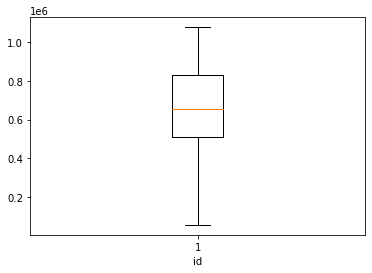

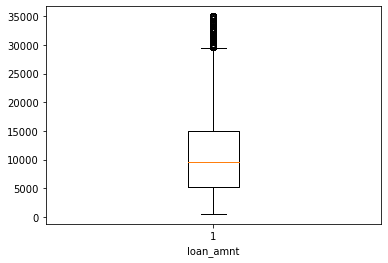

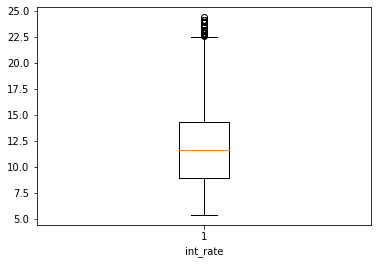

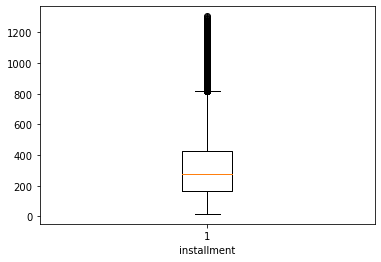

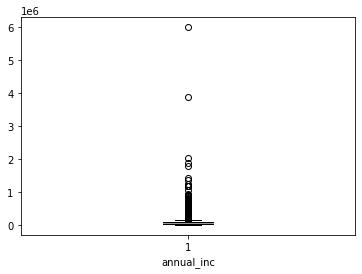

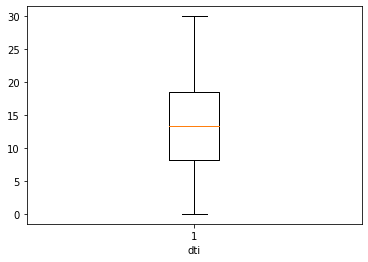

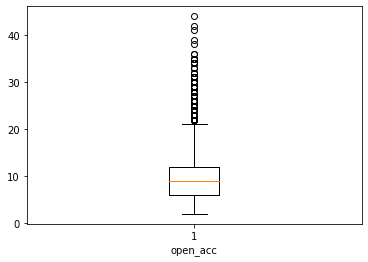

In [204]:
#Checking the distributions for numeric data and identifying relevant columns for business objective
def box_plot_col(df):
    i=1
    for col in df.columns:
        if df[col].dtype in ["int64","float64"]:
            # plt.subplot(1, 2, 1)
            # plt.hist(df[col])
            # plt.xlabel(col)
            #plt.subplot(1, 2, 2)
            plt.boxplot(df[col])
            plt.xlabel(col)
            #plt.tight_layout()
            plt.show()
box_plot_col(lc_df)

## EDA for Business Objective 1 :
### Reduce Credit loss from 'charged-off' customers who are the 'defaulters'. (Lending loans to ‘risky’ applicants) which is largest source of financial loss

In [205]:
# Univariate Analysis
# Functions for plotting graphs wrt columns as percentage


def plot_hist(df,column_name,bins):
    plot_data = (df[df["loan_status"]=="Fully Paid"][column_name],df[df["loan_status"]=="Charged Off"][column_name])
    #weight_data= (np.ones(len(plot_data[0])) / len(plot_data[0]+plot_data[1]),np.ones(len(plot_data[1])) / len(plot_data[0]+plot_data[1]))
    weight_data= (np.ones(len(plot_data[0])) / len(plot_data[0]),np.ones(len(plot_data[1])) / len(plot_data[1]))
    plt.figure(figsize=(20,10))
    n,bin_data,patches=plt.hist(plot_data,color=("g","r"),weights=weight_data,bins=bins)
    #plt.hist(plot_data,color=("g","r"))
    plt.xlabel(column_name,fontsize=22)
    plt.ylabel("Percentage",fontsize=22)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend(("Fully Paid","Charged Off"))
    plt.show()
    return n,bin_data,patches

def plot_hist_cat(df,column_name,width):
    df.plot.hist(column=["age"], by="gender", figsize=(10, 8))
    plt.figure(figsize=(20,10))
    plot_data = (df[df["loan_status"]=="Fully Paid"][column_name].value_counts().index)
    #plot_data = (df[df["loan_status"]=="Fully Paid"][column_name].value_counts().index,df[df["loan_status"]=="Charged Off"][column_name].value_counts().index)
    count_data = (df[df["loan_status"]=="Fully Paid"][column_name].value_counts().values,df[df["loan_status"]=="Charged Off"][column_name].value_counts().values)
    plt.bar(plot_data, count_data, width=width)
    plt.xlabel(column_name,fontsize=22)
    plt.ylabel("Frequency",fontsize=22)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(("Fully Paid","Charged Off"))
    plt.show()
    



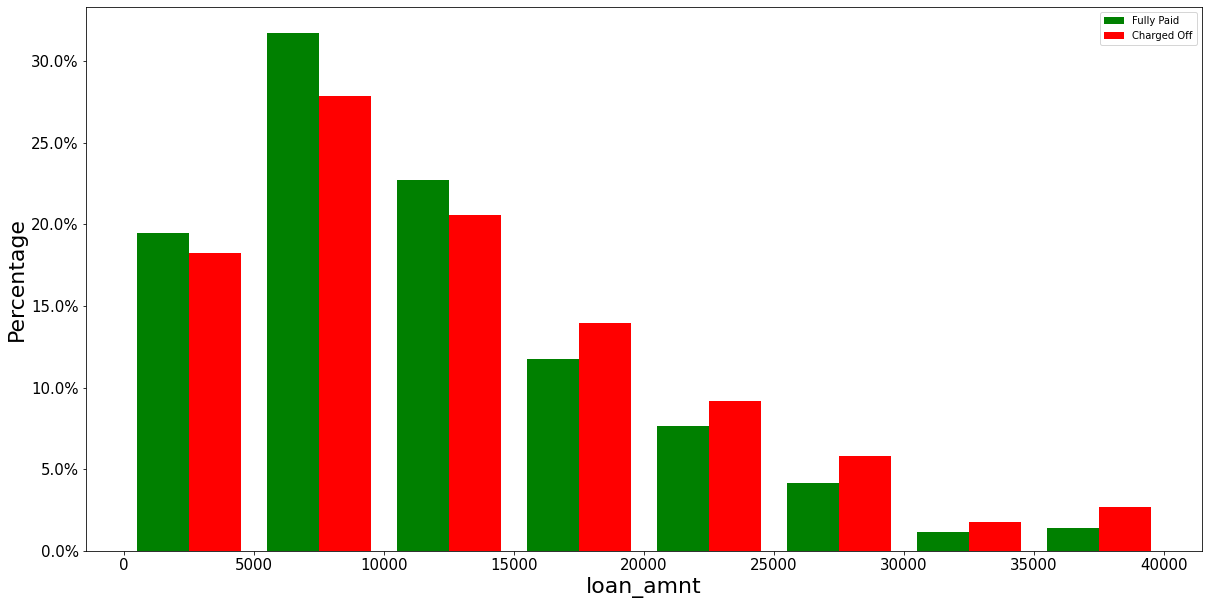

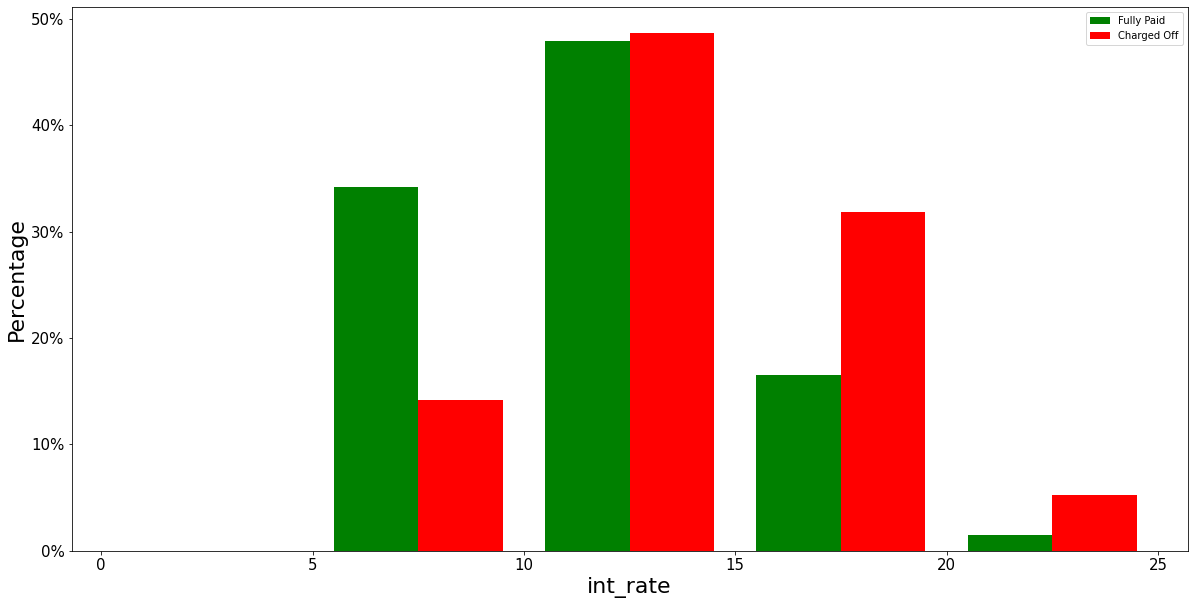

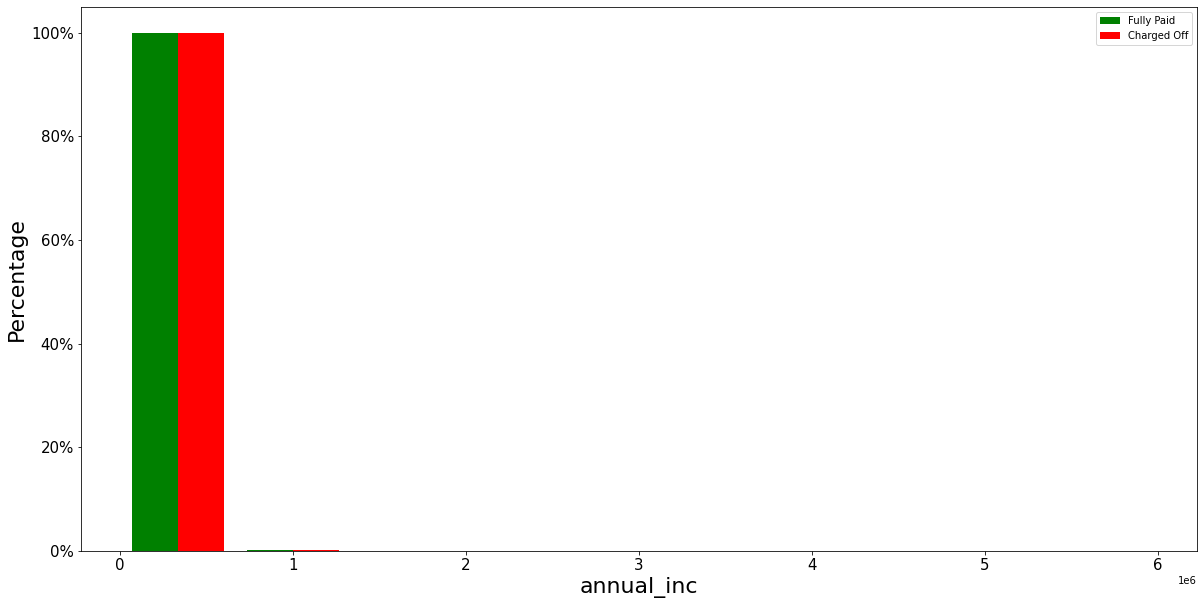

In [206]:
a1,b1,c1=plot_hist(lc_df,"loan_amnt",np.linspace(0,40000,num=9))
a2,b2,c2 = plot_hist(lc_df,"int_rate",np.linspace(0,25,num=6))
a3,b3,c3 = plot_hist(lc_df,"annual_inc",np.linspace(4000,6000000,num=10))

In [207]:
# Insights from the histogram
# No loan is offered from 0 to 5 % interest rate

# wrt interest rate
#1) Around 48% of the charged of customers fall under interest rate of 10 to 15 percentage
#2) 85 % of the charged off customers have taken the loan at an interest rate of > 10 %

# wrt loan_amnt
#1) 82 % of the charged customers have taken the loan amount > 5000
#2) 50 % of fully paid customers have taken the loan amont < 10000

In [208]:
num_cols=[]
for col in lc_df.columns:
    if lc_df[col].dtype in ["int64","float64"]:
        num_cols.append(col)
num_lc_df_corr=lc_df[num_cols].corr()
num_lc_df = lc_df[num_cols]

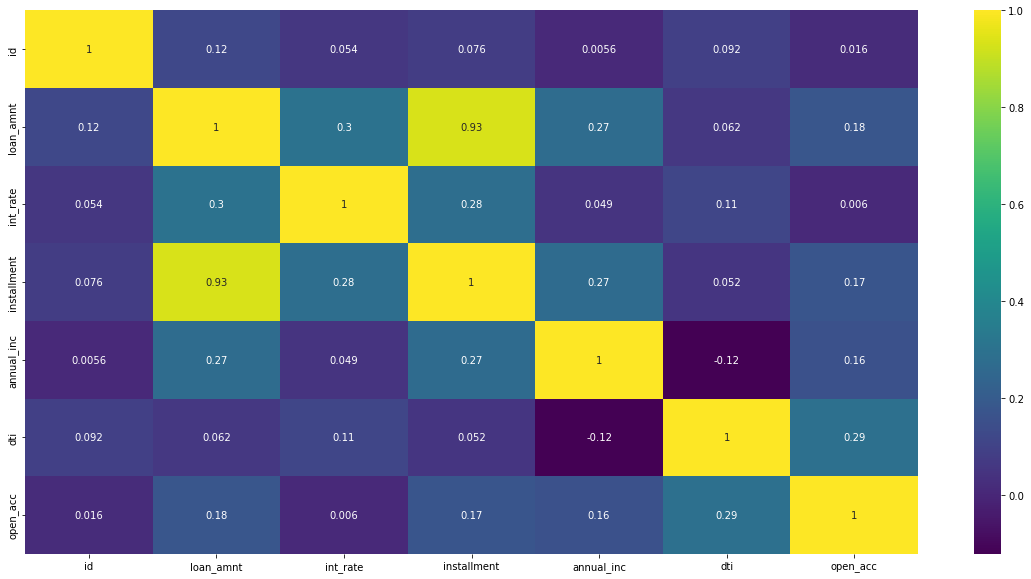

In [209]:
plt.figure(figsize=(20,10))
sns.heatmap(num_lc_df_corr,cmap="viridis",annot=True)
plt.show()

In [210]:
# sns.pairplot(num_lc_df.iloc[:,1:10])
# plt.show()

In [211]:
### Derived Metrics
#### earliest_cr_line to year
#### closed acc = total - open acc
#### ratio of funded_amt_inv to loan_amt